# Ornstein Uhlenbeck Hamiltonian Instanton Calculation

We calculate an Instanton in the OU model by solving the Hamiltonian Instanton equation from section III.A of [1].

We then compare this with the analytic solution.

[1] https://doi.org/10.1063/1.5084025

In [1]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt
import scipy.integrate

from tqdm.notebook import tqdm
from ham import Hamilton_solver

## Hamilton Equation Definitions

Here we define the RHS of the Hamilton equations for the instanton in the Kramer problem.

In [2]:
# Defining the RHS of Hamilton's Equations

def theta_rhs(t, state, s):
    """ Provides rhs of theta ODE. Will be passed to scipy integrator.
    - State should be of the form (time, ndim) where ndim is the number of theta variables.
    - If you want to use phi variables, put them in the s parameters NOT as state variables
    """
    p, phi = s
    gamma, sigma = p
    return gamma * state
    
    
def phi_rhs(t, state, s):
    """ Provides rhs of phi ODE. Will be passed to scipy integrator.
     - State should be of the form (time, ndim) where ndim is the number of phi variables.
     - If you want to use theta variables, put them in the s parameters NOT as state variables
    """
        
    # Unpacking state and parameters
    p, theta = s
    gamma, sigma = p
    
    return -gamma * state + theta

## Solving Hamilton Equations

In [31]:
##---------------------------------------------
## Set Up
##---------------------------------------------

# OU Parameters
gamma = 0.5
sigma = 0.1
p = [gamma, sigma]

# Time
steps = 100
dt = 0.1
T = steps * dt
time = np.arange(0, T + dt, dt)

# Initial Conditions
IC = rm.random((steps + 1, 2))

# Boundary Conditions 
phi0 = 0
IC[0, 0] = phi0
lamb = -100

# Observable
def F(x): 
    return x

In [32]:
# Algorithm Object Creation

rhs = [phi_rhs, theta_rhs]
ham_alg = Hamilton_solver(rhs, time, IC, p, update=[F, lamb])

In [33]:
# Run Algorithm

ham_alg.run(10)

## Comparison With Analytic Solution

In [34]:
# Defining Analytic Solution

def expA(t, p=p):
    "Returns exponential matrix at time t"
    gamma, sigma = p
    
    row1 = np.array([np.exp(- gamma * t), ( np.exp(gamma * t) - np.exp(-gamma * t) )/(2*gamma)])
    row2 = np.array([0, np.exp(gamma * t)])
    return np.vstack([row1, row2])

c = np.array([phi0, -lamb * np.exp(-gamma * T)])

analytic_solution = np.array([expA(t) @ c for t in time])

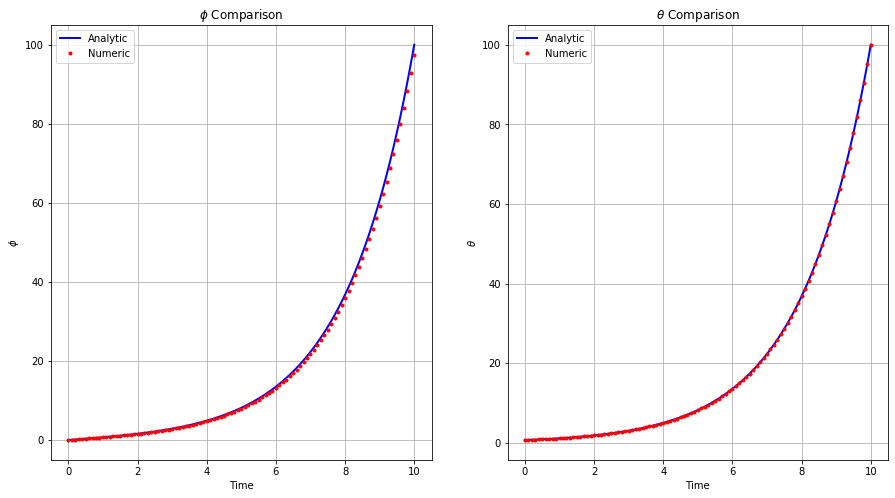

In [36]:
# Comparison Plot

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
labels = ['$\\phi$', '$\\theta$']

for (i, ax) in enumerate(axes):
    ax.grid()
    ax.set_title(labels[i] + ' Comparison')
    ax.plot(time, analytic_solution[:, i],'b', linewidth=2, label = 'Analytic')
    ax.plot(time, ham_alg.instanton[:, i], 'r.', label = 'Numeric')
    ax.set_xlabel('Time')
    ax.set_ylabel(labels[i])
    ax.legend()
fig.show()

## Checking Action has Been Minimised

In [30]:
# Defining utilitties for checking action being tracked.

def ou_a(t, x, p):
    "OU Drift"
    gamma, sigma = p
    return - gamma * x

class action_minimisation_checker:
    """Class for keeping track of instanton action comparisons."""
    
    def __init__(self, a, instanton, args):
        """ 
        param, a: Deterministic part of SDE, feeds in to action integral.
        param, instanton: the path we're comparing against
        param, args: arguments for a.
        """
        self.a = a
        self.p, self.dt = args
        
        # Instanton we will we check against
        self.instanton = instanton 
        self.action_value = self._action(instanton)
        
        self._compare_list = [(self.instanton, self.action_value)]
        self._smaller_list = []
        
    def _action(self, phi):
        """
        param, phi: is path we calculate action over    
        returns F-W action approximation where finite differences 
        are used to approximate the derivatives and integral.
        """
        v = np.gradient(phi, self.dt) -  self.a(0, phi, self.p)
        integrand =  v**2
        return 0.5 * np.trapz(integrand, dx=dt)
    
    def compare(self, path):
        """ Compare a provided path vs. the instanton.
        """
        x = self._action(path)
        self._add_comparison((path, x))
    
    @property
    def compared_paths(self):
        "Returns a list of tuples of compared paths and their action value"
        return self._compare_list
    
    def _add_comparison(self, path_tuple):
        self._compare_list.append(path_tuple)
        
    def any_smaller(self):
        "Checks if any compared path has a smaller action."
        for path_tuple in self.compared_paths:
            if (path_tuple[1] < self.action_value):
                print("Looks like a nearby path has a smaller action")
                self.add_smaller_path(path_tuple)
                print("I've made a note of this")
                return 
        print("Looks like it minimises")
        return
    @property
    def smaller_list(self):
        return self._smaller_list
    
    def add_smaller_path(self, x):
        self._smaller_list.append(x)
    
    def differences(self):
        "Prints differences in action for compared paths"
        for path_tuple in self.compared_paths:
            print(path_tuple[1] - self.action_value)

def eps_path(path, x):
    "Function that perturbs all non boundary points by x."
    ep = np.copy(path)
    ep[1:-1] += x
    return ep

### Comparing To Different Paths

We found in general it does minimise the aciton although there are some exceptions where it just about does not, see comments below.

In [11]:
instanton = ham_alg.phi_ts.flatten()

In [12]:
comparison_paths = [eps_path(instanton, - (10**-x)) for x in range(8)] # Contains some smaller action paths
# comparison_paths = [eps_path(instanton, (10**-x)) for x in range(10)] # Instanton smaller than all here
# comparison_paths = [eps_path(instanton, 0.1 * x) for x in range(10)] # Instanton smaller than all here
# comparison_paths = [eps_path(instanton, 0.2 * x) for x in range(10)] # Instanton smaller than all here
# comparison_paths = [eps_path(instanton, -0.2 * x) for x in range(10)] # Instanton smaller than all here

In [13]:
action_track = action_minimisation_checker(ou_a, instanton, [p, dt])

In [14]:
for path in comparison_paths:
    action_track.compare(path)

In [15]:
action_track.any_smaller()

Looks like a nearby path has a smaller action
I've made a note of this


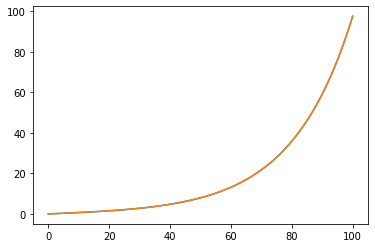

In [16]:
plt.plot(action_track.smaller_list[0][0])
plt.plot(instanton)

In [17]:
action_track.smaller_list[0][1]

4752.992158733139

In [18]:
len(action_track.smaller_list)

1